# RAG 시스템 보기


In [ ]:
import warnings
from retrieval import load_vectorstore_retriever_embeddings, rag
from model import llm_load
import json

warnings.filterwarnings("ignore")

# 1. 벡터스토어 로드

# 2. LLM 한 번만 로드 (재사용)
llm = llm_load()

/home/user/anaconda3/envs/knowledge_conflict/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer you are loading from './Mistral-Nemo-Instruct-2407' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Loading weights: 100%|██████████| 363/363 [00:29<00:00, 12.47it/s, Materializing param=model.norm.weight]                              


: 

In [2]:
# #3. test 데이터셋 가져오기
with open("datasets/popqa_dataset/qa_dataset.json", "r") as f:
    pop_qa = json.load(f)

with open("datasets/nq_dataset/qa_dataset.json", "r") as f:
    nq_qa = json.load(f)

with open("datasets/triviaqa_dataset/qa_dataset.json", "r") as f:
    trivia_qa = json.load(f)

with open("datasets/bioasq_dataset/qa_dataset.json", "r") as f:
    bioasq_qa = json.load(f)

### 테스트 데이터셋 랜덤 추출

In [3]:
from set_data import extract_random_qa

pop_qa_sampled = extract_random_qa(pop_qa, num_qa=260)
nq_qa_sampled = extract_random_qa(nq_qa, num_qa=260)
trivia_qa_sampled = extract_random_qa(trivia_qa, num_qa = 261)
bioasq_qa_sampled = extract_random_qa(bioasq_qa, num_qa=261)

### 최종 테스트 데이터셋 만들기 - 계속해서 바뀌니 주의할 것

In [5]:
import os
total_sampled = pop_qa_sampled + nq_qa_sampled + trivia_qa_sampled + bioasq_qa_sampled

for idx, item in enumerate(total_sampled):
    item["ids"] = str(idx)
    if "idx" in item:
        del item["idx"]

if not os.path.exists("datasets/total_qa_sampled"):
    os.makedirs("datasets/total_qa_sampled")


with open("datasets/total_qa_sampled/qa_dataset.json", "w") as f:
    json.dump(total_sampled, f, ensure_ascii=False, indent=2)

In [2]:
import json

with open('datasets/total_qa_sampled/qa_dataset.json', "r") as f:
    total_sampled = json.load(f)

### 역으로 QA 데이터셋을 만들어야겠는데

In [10]:
total_qa = []
with open("output/output_with_base_api_rag.jsonl","r") as f:
    for i, line in enumerate(f):
        result = json.loads(line)
        if i < 5:
            print(result)
        temp_result = {'ids' : str(i), 'question' : result['question'], 'answers' : result['ground_truth']}
        total_qa.append(temp_result)

with open("datasets/total_qa_sampled/qa_dataset_with_base_api_rag.json", "w") as f:
    json.dump(total_qa, f, ensure_ascii=False, indent=2)        
        

{'question': "What is J. Da Silva's occupation?", 'answers': " I don't know.", 'ground_truth': ['cricket umpire', 'umpire'], 'docs': [{'page_content': 'Jay Dasilva: 70\xa0m)[2]Position DefenderTeam informationCurrent team Coventry CityNumber 3Youth career2007–2012 Luton Town2012–2016 ChelseaSenior career*Years Team Apps (Gls)2016–2019 Chelsea 0 (0)2017 → Charlton Athletic (loan) 10 (0)2017–2018 → Charlton Athletic (loan) 38 (0)2018–2019 → Bristol City (loan) 28 (0)2019–2023 Bristol City 105 (2)2023– Coventry City 93 (0)International career‡2012–2013 England U16 4 (0)2013–2015 England U17 21 (1)2015–2016 England U18 4 (0)2016–2017 England U19 15 (0)2017–2018 England U20 6 (0)2018–2019 England U21 13 (0)2024– Wales 7 (0) * Club domestic league appearances and goals\xa0as of 17:10, 9 September 2025 (UTC)‡ National team caps and goals as of 20:55, 18 November 2025 (UTC) Jay Rhys Dasilva (born 22 April 1998) is a professional footballer who plays as a defender/left-wing back for EFL Champio

# Test with No RAG

In [4]:
from tqdm import tqdm
from model import llm_answer
from langchain_core.prompts import PromptTemplate
from prompt_template import NO_RAG_PROMPT_TEMPLATE


In [17]:
# output_file = "output/output_with_no_rag.jsonl"

# PROMPT = PromptTemplate(template=NO_RAG_PROMPT_TEMPLATE, input_variables=["question"])

# for item in tqdm(total_sampled[:],desc="No RAG 처리중"):
#     question = item["question"]
#     prompt = PROMPT.format(question=question)
#     answer = llm_answer(llm[0], llm[1], prompt)
#     ground_truth = item["answers"]

#     result = {
#         "question": question,
#         "answers": answer,
#         "ground_truth": ground_truth
#     }

#     with open(output_file, "a", encoding="utf-8") as f:
#         f.write(json.dumps(result, ensure_ascii=False) + "\n")

# print("저장 완료") # -> output/output_with_no_rag.jsonl

# Test with Wikipedia RAG

In [ ]:
# # 3. RAG 실행
# from tqdm import tqdm
# # 배치 설정 (수동으로 변경)

# output_file = f"output/output_with_base_rag.jsonl"  # JSON 형식


# for item in tqdm(total_sampled[:], desc="RAG 처리중"):
#     question = item["question"]
#     rag_output = rag(vectorstore, question, llm)
#     ground_truth = item["answers"]

#     # Document 객체 → dict 변환
#     docs_serialized = [
#         {"page_content": doc.page_content, "metadata": doc.metadata}
#         for doc in rag_output['source_documents']
#     ]
    
#     result = {
#         "question": question,
#         "answers": rag_output['answer'],
#         "ground_truth": ground_truth,
#         "docs": docs_serialized
#     }
    
#     # 한 줄씩 바로 저장 (append 모드)
#     with open(output_file, "a", encoding="utf-8") as f:
#         f.write(json.dumps(result, ensure_ascii=False) + "\n")
    
# print(f"저장 완료")  # -> output/output_with_base_rag.jsonl

RAG 처리중: 100%|██████████| 1042/1042 [35:08<00:00,  2.02s/it]

저장 완료


# Test with API RAG

In [3]:
#이제 API로 평가하면 됨
from tqdm import tqdm

output_file = f"output/output_with_base_api_rag.jsonl" 
#
from api_rag import web_rag

for item in tqdm(total_sampled[832:], desc="API RAG 처리중"):
    question = item["question"]
    rag_output = web_rag(question,llm, mode="mistral")
    ground_truth = item["answers"]

    docs_serialized = [
        {"page_content": doc["title"] + ": " + doc["paragraph"]}
        for doc in rag_output['source_documents']
    ]

    result = {
        "question": question,
        "answers": rag_output['answer'],
        "ground_truth": ground_truth,
        "docs": docs_serialized
    }

     # 한 줄씩 바로 저장 
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print(f"저장 완료")

API RAG 처리중:   0%|          | 0/210 [00:00<?, ?it/s]

API RAG 처리중: 100%|██████████| 210/210 [1:21:00<00:00, 23.15s/it]

저장 완료


### 평가하기

### 정확도 계산

In [4]:
from acc_prec import load_results, calculate_accuracy_by_dataset, calculate_precision_by_datasets

#### No RAG

In [5]:
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

results = load_results("output/output_with_no_rag.jsonl")
no_rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)

In [6]:
print("=== 데이터셋별 정확도 ===")
for name, accuracy in no_rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 정확도 ===
popqa: 28.5%
nq: 31.2%
triviaqa: 72.8%
bioasq: 47.9%
overall: 45.1%


#### RAG

In [7]:
# 데이터셋 크기 (순서대로: popqa, nq, triviaqa, bioasq)
dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

# 결과 로드 및 정확도 계산
results = load_results("output/output_with_base_api_rag.jsonl")
rag_accuracy = calculate_accuracy_by_dataset(results, dataset_sizes)
precision_dict = calculate_precision_by_datasets(results, dataset_sizes)

In [8]:
print("=== 데이터셋별 검색 정밀도 ===")
for name, precision in precision_dict.items():
    print(f"{name}: {precision:.1f}%")
print("=== 데이터셋별 정확도 ===")
for name, accuracy in rag_accuracy.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 검색 정밀도 ===
popqa: 39.9%
nq: 28.2%
triviaqa: 70.0%
bioasq: 33.9%
overall: 43.0%
=== 데이터셋별 정확도 ===
popqa: 54.6%
nq: 41.9%
triviaqa: 85.8%
bioasq: 56.7%
overall: 59.8%


### Astute RAG

In [ ]:
import json
from astute_rag import (
    combine_passage, make_internal_passage, make_external_passage, 
    make_prompts, make_passage_source, finalize_answer,
    make_internal_passage_batch, finalize_answer_batch  # 배치 버전 추가
)
from prompt_template import P_GEN, P_CON, P_ANS
from langchain_core.prompts import PromptTemplate
from acc_prec import load_results, calculate_accuracy_by_dataset_with_astute_rag

dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

with open("datasets/total_qa_sampled/qa_dataset.json", "r") as f:
    q = json.load(f)

P_gen, P_con, P_ans = make_prompts(P_GEN, P_CON, P_ANS)

E = make_external_passage()

# 배치 처리로 Internal passage 생성 (batch_size 조절 가능, GPU 메모리에 따라)
I = make_internal_passage_batch(q, P_gen, llm, batch_size=32)

combine_passages = combine_passage(E, I)

# 컨텍스트 미리 생성
contexts = []
questions = []
for i in range(len(q)):
    context = "\n\n".join([f"[{j+1}]\nsource: {doc['source']}, content: {doc['page_content']}" for j, doc in enumerate(combine_passages[i])])
    contexts.append(context)
    questions.append(q[i]['question'])

# 배치 처리로 최종 답변 생성
finalize_answers = finalize_answer_batch(llm, questions, contexts, batch_size=4)

results = load_results('./output/output_with_base_api_rag.jsonl')
acc_with_astute_rag = calculate_accuracy_by_dataset_with_astute_rag(results, dataset_sizes, finalize_answers)  
acc_with_astute_rag["overall"] = sum(acc_with_astute_rag.values()) / len(acc_with_astute_rag)

generating final answers (batch): 100%|██████████| 261/261 [4:46:28<00:00, 65.85s/it]   


### 마지막 Astute RAG에 대한 것도 저장

In [ ]:
# Astute RAG 결과 저장 (internal passage 포함)
with open("./output/output_with_astute_rag.jsonl", "w", encoding="utf-8") as f:
    for i, item in enumerate(results):
        result = {
            "question": item['question'],
            "answers": finalize_answers[i],  # Astute RAG 최종 답변
            "ground_truth": item['ground_truth'],
            "docs": item['docs'],  # external passages
            "internal_passage": I[i] if i < len(I) else None,  # internal passage
            "baseline_answer": item['answers']  # baseline RAG 답변 (비교용)
        }
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

print("저장 완료: ./output/output_with_astute_rag.jsonl")

저장 완료: ./output/output_with_astute_rag_2.jsonl


In [14]:
print("=== 데이터셋별 정확도 ===")
for name, accuracy in acc_with_astute_rag.items():
    print(f"{name}: {accuracy:.1f}%")

=== 데이터셋별 정확도 ===
popqa: 62.7%
nq: 49.6%
triviaqa: 91.6%
bioasq: 61.7%
overall: 66.4%


### Astute RAG with Gpt

In [1]:
import json
import gc
import torch
import os

from astute_rag import (
    combine_passage, make_internal_passage, make_external_passage, 
    make_prompts, make_passage_source, finalize_answer,
    make_internal_passage_batch, finalize_answer_batch, 
    consolidate_passages, consolidate_passages_batch
)
from prompt_template import P_GEN, P_CON, P_ANS
from langchain_core.prompts import PromptTemplate
from acc_prec import load_results, calculate_accuracy_by_dataset_with_astute_rag

dataset_sizes = {
    "popqa": 260,
    "nq": 260, 
    "triviaqa": 261,
    "bioasq": 261
}

with open("datasets/total_qa_sampled/qa_dataset.json", "r") as f:
    q = json.load(f)

P_gen, P_con, P_ans = make_prompts(P_GEN, P_CON, P_ANS)

E = make_external_passage()

# --- Internal passage: 저장된 파일 있으면 로드, 없으면 생성 후 저장 ---
internal_passage_path = "./output/internal_passages.json"
if os.path.exists(internal_passage_path):
    print(f"Internal passage 로드: {internal_passage_path}")
    with open(internal_passage_path, "r", encoding="utf-8") as f:
        I = json.load(f)
else:
    I = make_internal_passage_batch(q, P_gen, llm, batch_size=4)
    with open(internal_passage_path, "w", encoding="utf-8") as f:
        json.dump(I, f, ensure_ascii=False, indent=2)
    print(f"Internal passage 저장 완료: {internal_passage_path}")

combine_passages = combine_passage(E, I)
passage_source = make_passage_source(combine_passages)

# 컨텍스트 미리 생성
contexts = []
questions = []
for i in range(len(q)):
    context = "\n\n".join([f"[{j+1}]\nsource: {doc['source']}, content: {doc['page_content']}" for j, doc in enumerate(combine_passages[i])])
    contexts.append(context)
    questions.append(q[i]['question'])

# 메모리 정리 후 consolidation 진행
gc.collect()
torch.cuda.empty_cache()




/home/user/anaconda3/envs/knowledge_conflict/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Internal passage 로드: ./output/internal_passages.json


### BASELINE RAG 시각화

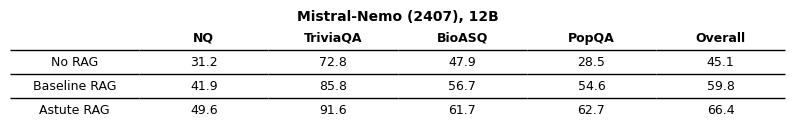

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
data = {
    'NQ': [0, 0, 0],
    'TriviaQA': [0, 0, 0],
    'BioASQ': [0, 0, 0],
    'PopQA': [0, 0, 0],
    'Overall': [0, 0, 0]
}

for key in data:
    acc = acc_with_astute_rag[str(key).lower()]
    data[key][2] = round(acc, 1)

for key in data:
    acc = no_rag_accuracy[str(key).lower()]
    data[key][0] = round(acc, 1)
    
for key in data:
    acc = rag_accuracy[str(key).lower()]
    data[key][1] = round(acc, 1)  


df = pd.DataFrame(data, index=['No RAG', 'Baseline RAG', 'Astute RAG'])

fig, ax = plt.subplots(figsize=(8, 1.5))
ax.axis('off')

col_labels = [''] + list(df.columns)
header_text = [['Mistral-Nemo (2407), 12B', '', '', '', '']]

table = ax.table(
    cellText=[[idx] + list(row) for idx, row in zip(df.index, df.values)],
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for j in range(len(col_labels)):
    table[(0, j)].set_facecolor('#ffffff')
    table[(0, j)].set_text_props(fontweight='bold')
    table[(0, j)].visible_edges = 'B' 

for i in range(1, len(df) + 1):
    for j in range(len(col_labels)):
        table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].visible_edges = 'B' if i < len(df) else ''

plt.text(0.5, 0.95, 'Mistral-Nemo (2407), 12B', ha='center', va='bottom', 
         fontsize=10, fontweight='bold', transform=ax.transAxes)

plt.tight_layout()
plt.show()

